In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from core.problem import ElementwiseProblem
from algorithms.moo.nsga2 import NSGA2
from constraints.as_obj import ConstraintsAsObjective
from constraints.as_obj import ModifiedConstraintsAsObjective
from constraints.from_bounds import ConstraintsFromBounds
from constraints.as_penalty import ConstraintsAsPenalty
from gradient.automatic import MyAutomaticDifferentiation
from optimize import minimize
from visualization.scatter import Scatter
from pymoo.problems import get_problem
from pymoo.util.plotting import plot

In [3]:
algorithm = NSGA2(pop_size=100)

In [4]:
import time

def performance_timer(func):
    """
    A decorator to measure and print the execution time of a function.
    """
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Capture the start time
        result = func(*args, **kwargs)  # Execute the function
        end_time = time.time()  # Capture the end time
        duration = end_time - start_time  # Calculate duration
        print(f"{func.__name__} executed in {duration:.6f} seconds")
        return result
    return wrapper

@performance_timer
def minimize_(*args, **kwargs):
    return minimize(*args, **kwargs)

In [5]:
@performance_timer
def compare_on(problem):
    res0 = minimize_(problem,
                     algorithm,
                     ('n_gen', 300),
                     seed=1,
                     verbose=False)

    res1 = minimize_(ConstraintsAsObjective(problem),
                     algorithm,
                     ('n_gen', 300),
                     seed=1,
                     verbose=False)

    res2 = minimize_(ModifiedConstraintsAsObjective(problem, config=dict(
        cache=True,
        cv_eps=0.0,
        cv_ieq=dict(scale=None, eps=0.0, pow=None, func=np.max),
        cv_eq=dict(scale=None, eps=1e-4, pow=None, func=np.max),
    )),
        algorithm,
        ('n_gen', 300),
        seed=1,
        verbose=False)
    
    res3 = minimize_(ModifiedConstraintsAsObjective(problem, config=dict(
        cache=True,
        cv_eps=0.0,
        cv_ieq=dict(scale=None, eps=0.0, pow=None, func=np.median),
        cv_eq=dict(scale=None, eps=1e-4, pow=None, func=np.median),
    )),
        algorithm,
        ('n_gen', 300),
        seed=1,
        verbose=False)

    return res0, res1, res2, res3

# Custom problem

In [6]:
class ConstrainedProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        super().__init__(n_var=2, n_obj=1, n_ieq_constr=1, n_eq_constr=0, xl=0, xu=2, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = x[0] ** 2 + x[1] ** 2
        out["G"] = 1.0 - (x[0] + x[1])

minimize_ executed in 2.759578 seconds
minimize_ executed in 2.034461 seconds
minimize_ executed in 1.941337 seconds
compare_on executed in 6.735682 seconds


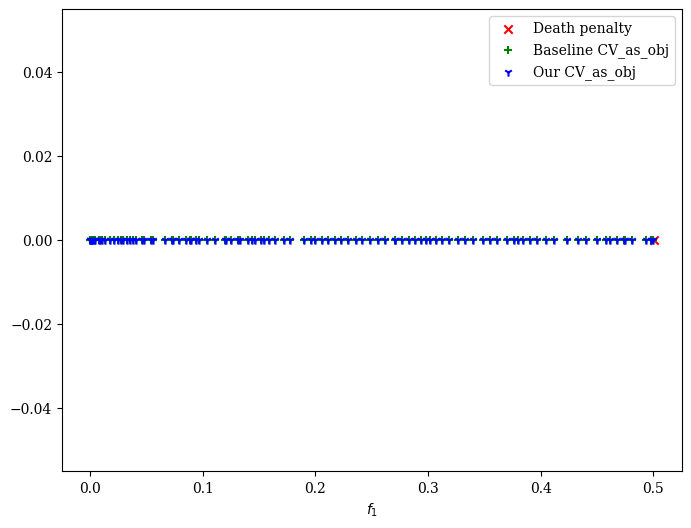

In [7]:
problem = ConstrainedProblem()

res0, res1, res2 = compare_on(problem)

plot = Scatter()
plot.add(problem.pareto_front(), marker="*", color="yellow", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, 1:], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, 1:], marker="1", color="blue", label='Our CV_as_obj')
plot.show()

In [ ]:
sum(res1.F - res2.F)

In [8]:
# from pymoo.core.evaluator import Evaluator
# from pymoo.core.individual import Individual

# cv = res1.F[:, 0]
# least_infeas = cv.argmin()
# x = res1.X[least_infeas]

# sol = Individual(X=x)
# Evaluator().eval(problem, sol)

# print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (sol.X, sol.F, sol.CV))

In [9]:
# cv = res2.F[:, 0]
# least_infeas = cv.argmin()
# x = res2.X[least_infeas]

# sol = Individual(X=x)
# Evaluator().eval(problem, sol)

# print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (sol.X, sol.F, sol.CV))

# ZDT

minimize_ executed in 1.609498 seconds
minimize_ executed in 1.759499 seconds
minimize_ executed in 1.869506 seconds
compare_on executed in 5.238792 seconds


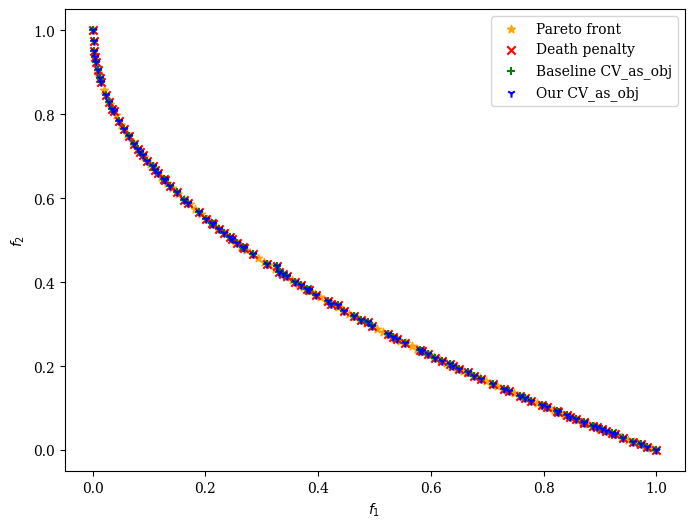

In [10]:
problem2 = get_problem("zdt1")

res0, res1, res2 = compare_on(problem2)

plot = Scatter()
plot.add(problem2.pareto_front(), marker="*", color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, 1:], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, 1:], marker="1", color="blue", label='Our CV_as_obj')
plot.show()

minimize_ executed in 1.682597 seconds
minimize_ executed in 1.794455 seconds
minimize_ executed in 1.834942 seconds
compare_on executed in 5.312280 seconds


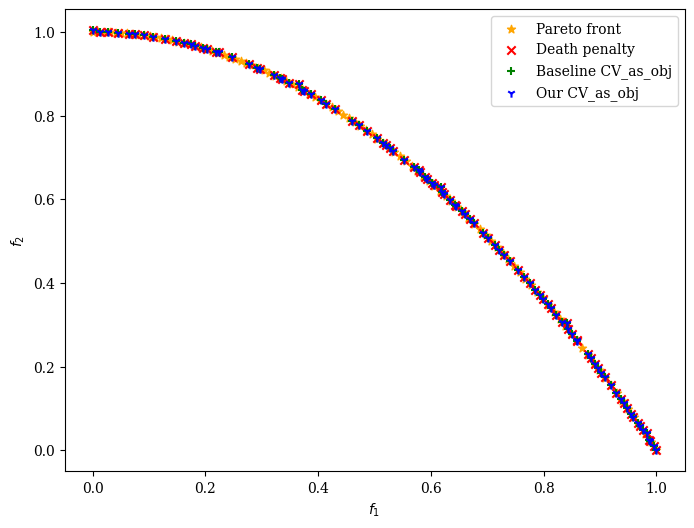

In [11]:
problem = get_problem("zdt2")

res0, res1, res2 = compare_on(problem)

plot = Scatter()
plot.add(problem.pareto_front(), marker="*", color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, 1:], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, 1:], marker="1", color="blue", label='Our CV_as_obj')
plot.show()

minimize_ executed in 1.701045 seconds
minimize_ executed in 1.824196 seconds
minimize_ executed in 2.008619 seconds
compare_on executed in 5.534180 seconds


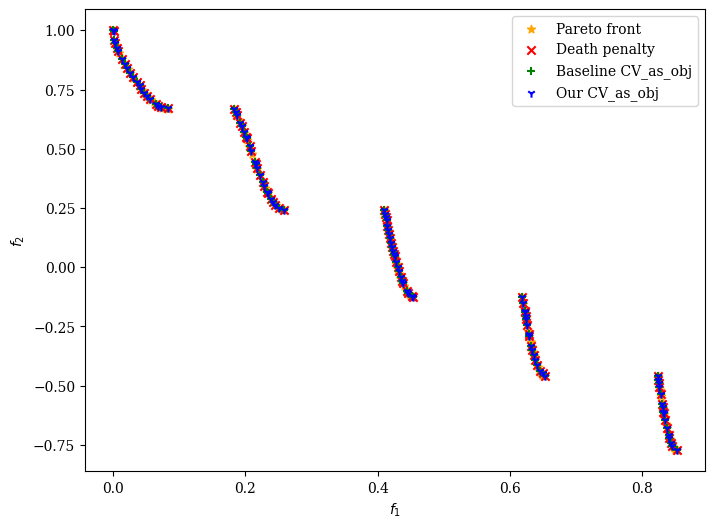

In [12]:
problem_zdt3 = get_problem("zdt3")

res0, res1, res2 = compare_on(problem_zdt3)

plot = Scatter()
plot.add(problem_zdt3.pareto_front(), marker="*", color="orange", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, 1:], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, 1:], marker="1", color="blue", label='Our CV_as_obj')
plot.show()

minimize_ executed in 1.647399 seconds
minimize_ executed in 1.831788 seconds
minimize_ executed in 1.719846 seconds
compare_on executed in 5.199714 seconds


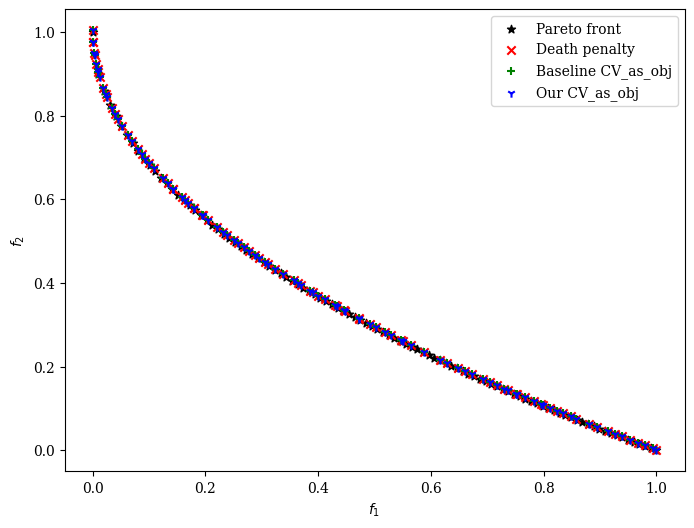

In [13]:
problem = get_problem("zdt4")

res0, res1, res2 = compare_on(problem)

plot = Scatter()
plot.add(problem.pareto_front(), marker="*", color="black", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, 1:], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, 1:], marker="1", color="blue", label='Our CV_as_obj')
plot.show()

minimize_ executed in 2.434479 seconds
minimize_ executed in 2.233121 seconds
minimize_ executed in 2.154693 seconds
compare_on executed in 6.822750 seconds


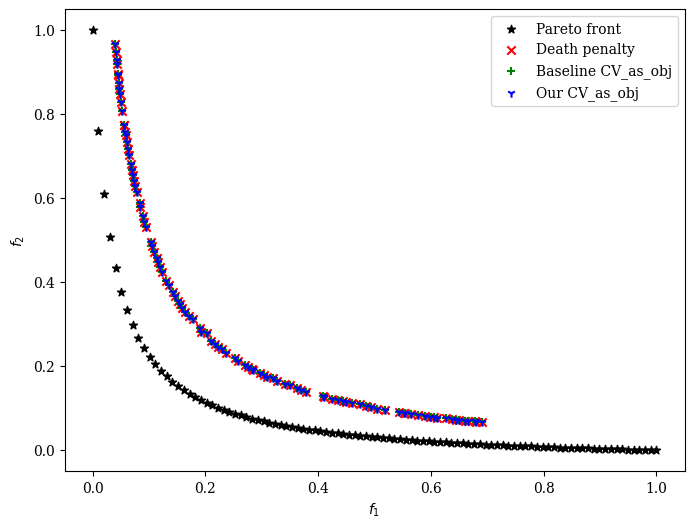

In [14]:
problem_zdt5 = get_problem("zdt5")

res0, res1, res2 = compare_on(problem_zdt5)

plot = Scatter()

plot.add(problem_zdt5.pareto_front(), marker="*",
         color="black", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, 1:], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, 1:], marker="1", color="blue", label='Our CV_as_obj')

plot.show()

minimize_ executed in 1.657296 seconds
minimize_ executed in 1.786089 seconds
minimize_ executed in 1.813180 seconds
compare_on executed in 5.256878 seconds


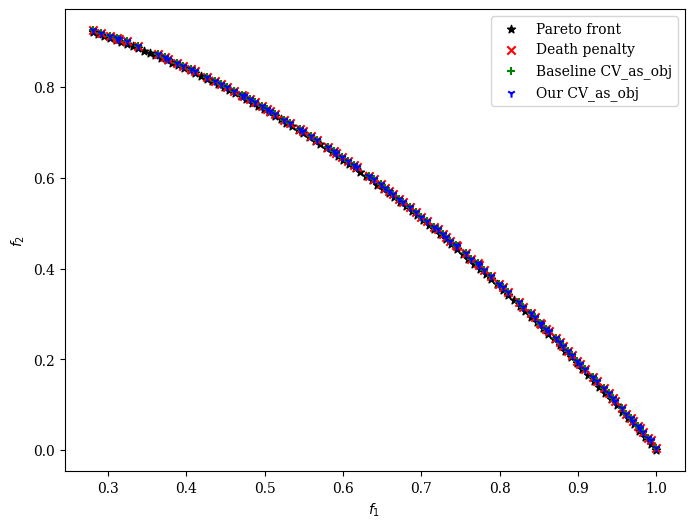

In [15]:
problem_zdt6 = get_problem("zdt6")

res0, res1, res2 = compare_on(problem_zdt6)

plot = Scatter()

plot.add(problem_zdt6.pareto_front(), marker="*",
         color="black", label='Pareto front')
plot.add(res0.F, marker="x", color="red", label='Death penalty')
plot.add(res1.F[:, 1:], marker="+", color="green", label='Baseline CV_as_obj')
plot.add(res2.F[:, 1:], marker="1", color="blue", label='Our CV_as_obj')

plot.show()

In [16]:
res1.F - res2.F

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0

In [17]:
# cv = res3.F[:, 0]
# least_infeas = cv.argmin()
# x = res3.X[least_infeas]

# sol = Individual(X=x)
# Evaluator().eval(problem2, sol)

# print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (sol.X, sol.F, sol.CV))

In [18]:
# plot = Scatter()
# plot.add(problem2.pareto_front(), marker="*", color="black", alpha=0.7, s=100)
# plot.add(res3.F[:,1:], facecolor="none", edgecolor="red")
# plot.show()

In [19]:
# X, F = res3.opt.get("X", "F")
# hist = res3.history
# print(len(hist))

In [20]:
# n_evals = []             # corresponding number of function evaluations\
# hist_F = []              # the objective space values in each generation
# hist_cv = []             # constraint violation in each generation
# hist_cv_avg = []         # average constraint violation in the whole population

# for algo in hist:

#     # store the number of function evaluations
#     n_evals.append(algo.evaluator.n_eval)

#     # retrieve the optimum from the algorithm
#     opt = algo.opt

#     # store the least contraint violation and the average in each population
#     hist_cv.append(opt.get("CV").min())
#     hist_cv_avg.append(algo.pop.get("CV").mean())

#     # filter out only the feasible and append and objective space values
#     feas = np.where(opt.get("feasible"))[0]
#     hist_F.append(opt.get("F")[feas])

In [21]:
# k = np.where(np.array(hist_cv) <= 0.0)[0].min()
# print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

In [22]:
# # replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population
# vals = hist_cv_avg

# k = np.where(np.array(vals) <= 0.0)[0].min()
# print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

# plt.figure(figsize=(7, 5))
# plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
# plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
# plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
# plt.title("Convergence")
# plt.xlabel("Function Evaluations")
# plt.ylabel("Hypervolume")
# plt.legend()
# plt.show()

In [23]:
# approx_ideal = F[:,-2:].min(axis=0)
# approx_nadir = F[:,-2:].max(axis=0)
# approx_ideal, approx_nadir

In [24]:
# from pymoo.indicators.hv import Hypervolume

# metric = Hypervolume(ref_point=np.array([0.1, 0.1]),
#                      norm_ref_point=False,
#                      zero_to_one=True,
#                      ideal=approx_ideal,
#                      nadir=approx_nadir)

# hv = [metric.do(_F[:, -2:]) for _F in hist_F]

# plt.figure(figsize=(7, 5))
# plt.plot(n_evals, hv, color='black', lw=0.7, label="Avg. CV of Pop")
# plt.scatter(n_evals, hv, facecolor="none", edgecolor='black', marker="p")
# plt.title("Convergence")
# plt.xlabel("Function Evaluations")
# plt.ylabel("Hypervolume")
# plt.show()

In [25]:
# from pymoo.util.running_metric import RunningMetricAnimation

# running = RunningMetricAnimation(delta_gen=5,
#                         n_plots=3,
#                         key_press=False,
#                         do_show=True)

# for algorithm in res3.history[:50]:
#     running.update(algorithm)

In [26]:
# from pymoo.indicators.igd import IGD

# metric = IGD(pf, zero_to_one=True)

# igd = [metric.do(_F) for _F in hist_F]

# plt.plot(n_evals, igd,  color='black', lw=0.7, label="Avg. CV of Pop")
# plt.scatter(n_evals, igd,  facecolor="none", edgecolor='black', marker="p")
# plt.axhline(10**-2, color="red", label="10^-2", linestyle="--")
# plt.title("Convergence")
# plt.xlabel("Function Evaluations")
# plt.ylabel("IGD")
# plt.yscale("log")
# plt.legend()
# plt.show()

# Welded Beam

minimize_ executed in 2.117833 seconds
minimize_ executed in 1.871217 seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


minimize_ executed in 1.845991 seconds
compare_on executed in 5.835317 seconds


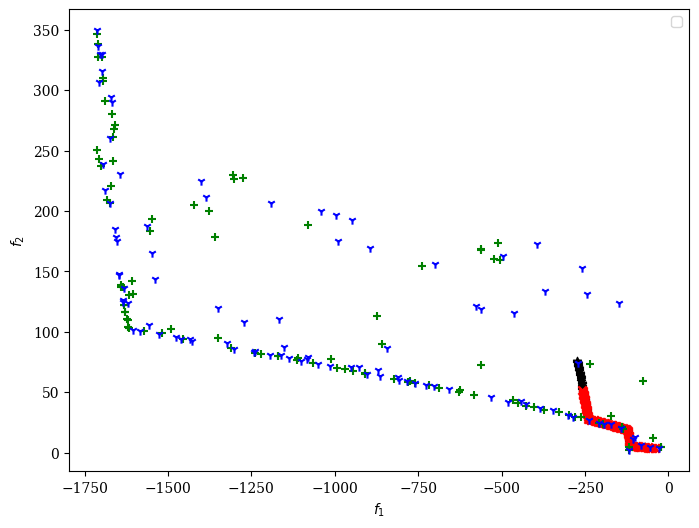

In [27]:
problem3 = get_problem("osy")

res0, res1, res2 = compare_on(problem3)

plot = Scatter()
plot.add(problem3.pareto_front(), marker="*", color="black")
plot.add(res0.F, marker="x", color="red")
plot.add(res1.F[:, 1:], marker="+", color="green")
plot.add(res2.F[:, 1:], marker="1", color="blue")
plot.show()

In [33]:
sum(res1.F - res2.F)

array([   47.59422741, -5424.00270814,   439.06729409])

In [29]:
# from pymoo.core.evaluator import Evaluator
# from pymoo.core.individual import Individual

# cv = res4.F[:, 0]
# least_infeas = cv.argmin()
# x = res4.X[least_infeas]

# sol = Individual(X=x)
# Evaluator().eval(problem3, sol)

# print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (sol.X, sol.F, sol.CV))

In [30]:
# res4.F[:,-2:].shape

In [31]:
# plot = Scatter()
# plot.add(problem3.pareto_front(), marker="*", color="black", alpha=0.7, s=100)
# plot.add(res4.F[:,-2:], facecolor="none", edgecolor="red")
# plot.show()

In [32]:
terminate_here

NameError: name 'terminate_here' is not defined

# Diversity Factor

In [ ]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from scipy.spatial import cKDTree
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover as SBX
from pymoo.operators.mutation.pm import PolynomialMutation as PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.core.callback import Callback

In [ ]:
from annoy import AnnoyIndex


class DiversityEnhancedProblem(Problem):
    def __init__(self, problem, neighbors=5, trees=10):
        super().__init__(n_var=problem.n_var,
                         n_obj=problem.n_obj + 1,
                         n_constr=problem.n_constr,
                         xl=problem.xl,
                         xu=problem.xu)
        self.base_problem = problem
        self.neighbors = neighbors
        self.population = []
        self.tree = AnnoyIndex(self.n_var, 'manhattan')
        self.tree_cache = {}  # To store diversity values
        self.trees = trees  # Number of trees for Annoy

    def update_population(self, pop):
        self.population = pop.get("X")
        self.tree.unbuild()  # Clear the current tree
        for i, x in enumerate(self.population):
            self.tree.add_item(i, x.tolist())
        self.tree.build(self.trees)
        self.tree_cache = {}  # Clear cache after update

    def calculate_diversity(self, x):
        if len(self.population) > 1:
            distances = self.tree.get_nns_by_vector(
                x, self.neighbors, include_distances=True)[1]
            return 1.0 / np.mean(distances)
        return 0

    def _evaluate(self, x, out, *args, **kwargs):
        base_out = {}
        self.base_problem._evaluate(x, base_out, *args, **kwargs)
        f = base_out["F"]
        x = np.atleast_2d(x)

        # Calculate diversity, using cache if available
        diversity = np.array([self.tree_cache.get(
            tuple(xi), self.calculate_diversity(xi)) for xi in x])
        for xi, div in zip(x, diversity):
            self.tree_cache[tuple(xi)] = div  # Update cache

        out["F"] = np.column_stack([f, diversity])


class DiversityCallback(Callback):
    def __init__(self, problem):
        super().__init__()
        self.problem = problem

    def notify(self, algorithm):
        self.problem.update_population(algorithm.pop)


# Original problem from pymoo
original_problem = get_problem("zdt2")

# Enhanced problem with diversity objective
problem = DiversityEnhancedProblem(original_problem, neighbors=10)

# Setup the algorithm
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Execute the optimization
res1 = minimize(
    problem,
    algorithm,
    ('n_gen', 10000),
    verbose=True,
    seed=1,
    callback=DiversityCallback(problem)
)

res2 = minimize(
    original_problem,
    algorithm,
    ('n_gen', 2000),
    verbose=False,
    seed=0,
    # callback=DiversityCallback(problem)
)

In [ ]:
print(res1.F.shape, res2.F.shape)

In [ ]:
from visualization.scatter import Scatter

plot = Scatter()
plot.add(res1.F[:,:-1], facecolor="none", edgecolor="red")
plot.add(res2.F, facecolor="none", edgecolor="blue")
plot.show()

In [ ]:
from visualization.scatter import Scatter

plot = Scatter()
plot.add(res1.F, facecolor="none", edgecolor="red")
# plot.add(res2.F, facecolor="none", edgecolor="blue")
plot.show()

In [ ]:
from pymoo.factory import get_performance_indicator

# Assuming 'result' is the output of your optimization algorithm
hv = get_performance_indicator("hv", ref_point=np.array([1.1, 1.1]))  # Adjust ref_point as needed
hypervolume = hv.calc(res1.F)

print("Hypervolume:", hypervolume)

In [ ]:
from annoy import AnnoyIndex
import numpy as np


class DiversityEnhancedProblem2(Problem):
    def __init__(self, problem, neighbors=5, trees=10, update_interval=5, change_threshold=0.2):
        super().__init__(n_var=problem.n_var,
                         n_obj=problem.n_obj + 1,
                         n_constr=problem.n_constr,
                         xl=problem.xl,
                         xu=problem.xu)
        self.base_problem = problem
        self.neighbors = neighbors
        self.population = []
        self.tree = AnnoyIndex(self.n_var, 'euclidean')
        self.trees = trees
        self.update_interval = update_interval
        self.change_threshold = change_threshold
        self.generation_count = 0
        self.last_population = None

    def update_population(self, pop):
        self.population = pop.get("X")
        self.generation_count += 1

        # Determine if the tree needs updating
        if self.last_population is None or self.generation_count % self.update_interval == 0 or self.population_has_changed():
            self.rebuild_tree()
            self.last_population = np.array(self.population.copy())
            print("Tree rebuilt.")

    def population_has_changed(self):
        """ Checks if significant changes have occurred in the population """
        if self.last_population is not None:
            dists = np.linalg.norm(
                self.last_population - self.population, axis=1)
            significant_changes = np.mean(dists > self.change_threshold)
            # More than 10% of the population has significantly changed
            return significant_changes > 0.1
        return False

    def rebuild_tree(self):
        """ Rebuilds the Annoy index """
        self.tree.unbuild()
        for i, x in enumerate(self.population):
            self.tree.add_item(i, x.tolist())
        self.tree.build(self.trees)

    def calculate_diversity(self, x):
        if len(self.population) > 1:
            distances = self.tree.get_nns_by_vector(
                x, self.neighbors, include_distances=True)[1]
            return 1.0 / np.mean(distances)
        return 0

    def _evaluate(self, x, out, *args, **kwargs):
        base_out = {}
        self.base_problem._evaluate(x, base_out, *args, **kwargs)
        f = base_out["F"]
        x = np.atleast_2d(x)

        # Calculate diversity
        diversity = np.array([self.calculate_diversity(xi) for xi in x])
        out["F"] = np.column_stack([f, diversity])


# Original problem from pymoo
original_problem = get_problem("zdt2")

# Enhanced problem with diversity objective
problem2 = DiversityEnhancedProblem2(original_problem, neighbors=10)

# Setup the algorithm
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Execute the optimization
res1 = minimize(
    problem2,
    algorithm,
    ('n_gen', 5000),
    verbose=True,
    seed=1,
    callback=DiversityCallback(problem)
)

res2 = minimize(
    original_problem,
    algorithm,
    ('n_gen', 2000),
    verbose=False,
    seed=0,
)

from visualization.scatter import Scatter

plot = Scatter()
plot.add(res1.F[:,1:], facecolor="none", edgecolor="red")
plot.add(res2.F, facecolor="none", edgecolor="blue")
plot.show()

In [ ]:
from pymoo.core.problem import Problem
import numpy as np

class ConstraintAsObjectiveProblem(Problem):
    def __init__(self, problem):
        super().__init__(n_var=problem.n_var,
                         n_obj=problem.n_obj + problem.n_constr,
                         n_constr=0,  # No explicit constraints as they are now objectives
                         xl=problem.xl,
                         xu=problem.xu)
        self.problem = problem

    def _evaluate(self, x, out, *args, **kwargs):
        # Evaluate the original problem
        res = {}
        self.problem._evaluate(x, res)

        # Combine original objectives with constraints as new objectives
        f = res["F"]
        g = np.where(res["G"] > 0, res["G"], 0)  # Constraint violation for g(x) > 0
        h = np.abs(res["H"])  # Absolute value for equality constraints
        
        # Combine into a single objective array
        out["F"] = np.column_stack([f, g, h])


In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.selection.tournament import compare
from pymoo.optimize import minimize
from pymoo.problems import get_problem


class FeasibilityFirstNSGA2(NSGA2):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _next(self):
        # Overriding the selection process to prioritize feasibility
        def feasibility_first(a, b):
            # Check if either solution is feasible
            is_feasible_a = np.all(self.pop[a].get(
                "F")[self.problem.n_obj:] <= 0)
            is_feasible_b = np.all(self.pop[b].get(
                "F")[self.problem.n_obj:] <= 0)

            if is_feasible_a and not is_feasible_b:
                return a
            elif not is_feasible_a and is_feasible_b:
                return b
            else:
                # If both are feasible or infeasible, fall back to regular comparison
                return compare(a, b, self.pop, self.n_survive, self.rank_key, self.crowding_key)

        # Tournament selection modified for feasibility
        mating_pool = self.selection(
            self.pop, self.n_offsprings, feasibility_first)
        off = self.crossover.do(self.problem, self.pop, mating_pool)
        off = self.mutation.do(self.problem, off)
        self.evaluator.eval(self.problem, off)
        self.pop = self.survival.do(
            self.problem, self.pop, off, n_survive=self.pop_size)


problem = get_problem("zdt1")
wrapped_problem = ConstraintAsObjectiveProblem(problem)

algorithm = FeasibilityFirstNSGA2(pop_size=100)

res = minimize(wrapped_problem,
               algorithm,
               ('n_gen', 100),
               verbose=True)